In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from utils import *
from algorithm import *

In [2]:
def get_all_ols_ests_one_trial(d, sigmas, bs_star, ys, As):
    # OLS estimates
    n = bs_star.shape[0]
    ols_ests = get_n_est(ys, As, get_ols, [None]*n)

    # Ridge estimate for comparison
    lambds = np.divide(d*(sigmas**2), 2*np.sum(bs_star**2, 1))
    lambds_mult = np.divide(1, 1 + 2*lambds)
    ridge_ests = get_n_est(ys, As, get_ridge, lambds_mult)

    # OLS. best linear fusion results if we had b_star
    W_star = get_ols_weights(bs_star, d, sigmas)

    # OLS. iterative fusion, update W and bs_hat
    new_est = ols_ests
    W_hats = []
    for ii in range(num_iter):
        W_hat = get_ols_weights(new_est, d, sigmas)
        new_est = W_hat.dot(new_est)
        W_hats.append(W_hat)

    return (ols_ests, ridge_ests, W_star, W_hats)

# Phase transition diagram
Central model

- $\beta^\star \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$, $\beta^\star \in \mathbb{R}^d$.
- $\beta^\star_i \sim \mathcal{N}(\beta^\star, \sigma_{\star}^2\mathbf{I})$.
- $\mathbf{y}_i \sim \mathcal{N}(\mathbf{A}_i\beta^\star_i, \sigma_i^2\mathbf{I})$
- $\mathbf{A}_i \in \mathbb{R}^{m\times d}$, $m = d$, $\mathbf{A}_i$ is orthogonal.

## variables of interest
- number of machines $n$
- task similarity "snr" - $10\log_{10}(\|\beta^\star\|_2^2/d {\sigma_\star}^2 )$
- noisy input snr -  $10\log_{10}(\|\beta^i\|_2^2/d {\sigma_i}^2 )$

- Fixed d = 20
- Assumed $\beta^\star \sim N(0, I)$ fixes $\|\beta^\star\|_2^2 = d$
- Sweep $\sigma_\star, \sigma_i$ in logspace.
- Sweep n.

In [3]:
num_trial = 10
num_iter = 5
d = 20 # dimension of beta (ground truth)
m = d# dimension of y (observation)

ns = range(1, 31) # number of tasks/nodes
gt_sigmas = np.logspace(-1.5, 1, 31)
obs_sigmas = np.logspace(-1.5, 1, 31)

In [4]:
err_fusion = np.zeros((num_trial, num_iter, len(obs_sigmas), len(gt_sigmas), len(ns)))
err_ols_local = np.zeros((num_trial, len(obs_sigmas), len(gt_sigmas), len(ns)))
err_fusion_star = np.zeros((num_trial, len(obs_sigmas), len(gt_sigmas), len(ns)))
err_ridge_local = np.zeros((num_trial, len(obs_sigmas), len(gt_sigmas), len(ns)))

for rr in range(len(ns)):
    for kk in range(len(gt_sigmas)):
        for jj in range(len(obs_sigmas)):
            for trial in range(num_trial):

                # generate data
                bs_star, As, sigmas, ys = generate_data_central_model(d, ns[rr], m, gt_sigmas[kk], obs_sigmas[jj])

                # get estimates
                ols_ests, ridge_ests, W_star, W_hats = get_all_ols_ests_one_trial(d, sigmas, bs_star, ys, As)

                # get MSE
                err_ols_local[trial, jj, kk, rr] = get_mse(ols_ests, bs_star)
                err_ridge_local[trial, jj, kk, rr] = get_mse(ridge_ests, bs_star)
                err_fusion_star[trial, jj, kk, rr] = get_mse(W_star.dot(ols_ests), bs_star)
                
                new_est = ols_ests

                for ii in range(num_iter):
                    new_est = W_hats[ii].dot(new_est)
                    err_fusion[trial, ii, jj, kk, rr] = get_mse(new_est, bs_star)

In [5]:
input_snr = 10*np.log10(1/(obs_sigmas**2))
task_sim_snr = 10*np.log10(1/(gt_sigmas**2))
print(input_snr)
print(task_sim_snr)

err_ols_local_snr = -10*np.log10(np.mean(err_ols_local, axis=0))
err_ridge_local_snr = -10*np.log10(np.mean(err_ridge_local, axis=0))

err_fusion_snr = -10*np.log10(np.mean(np.min(err_fusion, axis=1), axis=0))
err_fusion_star_snr = -10*np.log10(np.mean(err_fusion_star, axis=0))
print(err_ridge_local_snr.shape, err_fusion_snr.shape)

[ 30.          28.33333333  26.66666667  25.          23.33333333
  21.66666667  20.          18.33333333  16.66666667  15.
  13.33333333  11.66666667  10.           8.33333333   6.66666667
   5.           3.33333333   1.66666667   0.          -1.66666667
  -3.33333333  -5.          -6.66666667  -8.33333333 -10.
 -11.66666667 -13.33333333 -15.         -16.66666667 -18.33333333
 -20.        ]
[ 30.          28.33333333  26.66666667  25.          23.33333333
  21.66666667  20.          18.33333333  16.66666667  15.
  13.33333333  11.66666667  10.           8.33333333   6.66666667
   5.           3.33333333   1.66666667   0.          -1.66666667
  -3.33333333  -5.          -6.66666667  -8.33333333 -10.
 -11.66666667 -13.33333333 -15.         -16.66666667 -18.33333333
 -20.        ]
(31, 31, 30) (31, 31, 30)


In [6]:
np.savez('phase_transition.npz', input_snr=input_snr, task_sim_snr=task_sim_snr, err_ols_local_snr=err_ols_local_snr, err_ridge_local_snr=err_ridge_local_snr, 
         err_fusion_snr=err_fusion_snr, err_fusion_star_snr=err_fusion_star_snr, 
        ns=ns, gt_sigmas=gt_sigmas, obs_sigmas=obs_sigmas, d=d, m=m, num_iter=num_iter, num_trial=num_trial)

In [7]:
test_npz = np.load('phase_transition.npz')
print(test_npz.files)
print(test_npz['ns'])

['input_snr', 'task_sim_snr', 'err_ols_local_snr', 'err_ridge_local_snr', 'err_fusion_snr', 'err_fusion_star_snr', 'ns', 'gt_sigmas', 'obs_sigmas', 'd', 'm', 'num_iter', 'num_trial']
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]


## slice at n = d = 20

20


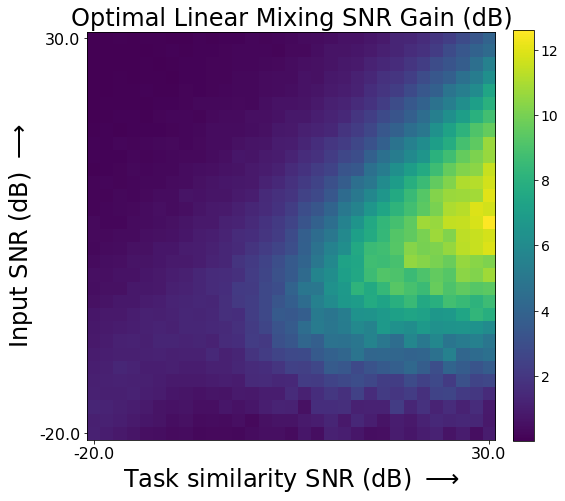

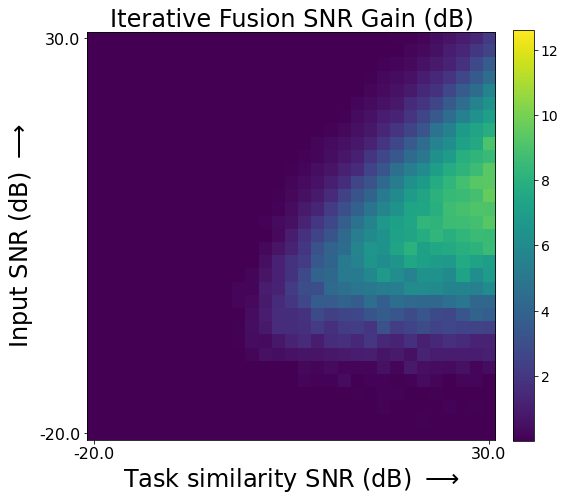

In [8]:
idx = 19
print(ns[idx])

ref = err_fusion_star_snr[:, :, idx] - err_ridge_local_snr[:, :, idx]
val = err_fusion_snr[:, :, idx] - err_ridge_local_snr[:, :, idx]

plt.figure(figsize=(8, 8))
im = plt.imshow(ref, vmin=ref.min(), vmax=ref.max())
plt.gca().invert_xaxis()
plt.xticks([0,30], task_sim_snr[[0, -1]], fontsize=16)
plt.xlabel(r'Task similarity SNR (dB) $\longrightarrow$', fontsize=24)
plt.yticks([0,30], input_snr[[0, -1]], fontsize=16)
plt.ylabel(r'Input SNR (dB) $\longrightarrow$', fontsize=24)
cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=14)
plt.title('Optimal Linear Mixing SNR Gain (dB)', fontsize=24)
plt.savefig('fixed_n_phase_star.pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(8, 8))
im = plt.imshow(val, vmin=ref.min(), vmax=ref.max())
plt.gca().invert_xaxis()
plt.xticks([0,30], task_sim_snr[[0, -1]], fontsize=16)
plt.xlabel(r'Task similarity SNR (dB) $\longrightarrow$', fontsize=24)
plt.yticks([0,30], input_snr[[0, -1]], fontsize=16)
plt.ylabel(r'Input SNR (dB) $\longrightarrow$', fontsize=24)
cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=14)
plt.title('Iterative Fusion SNR Gain (dB)', fontsize=24)
plt.savefig('fixed_n_phase.pdf', bbox_inches='tight')
plt.show()

## slice at task similarity SNR = 10 dB

10.0


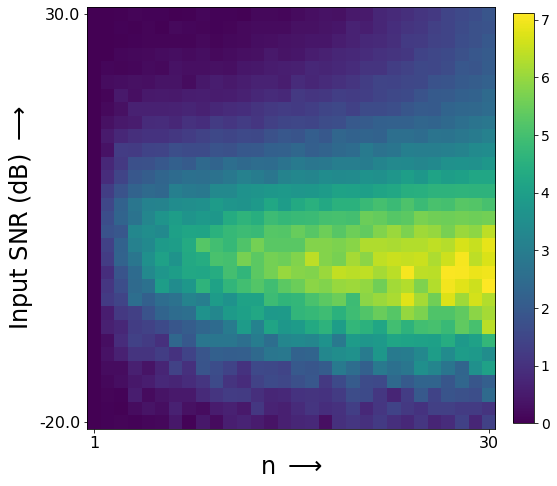

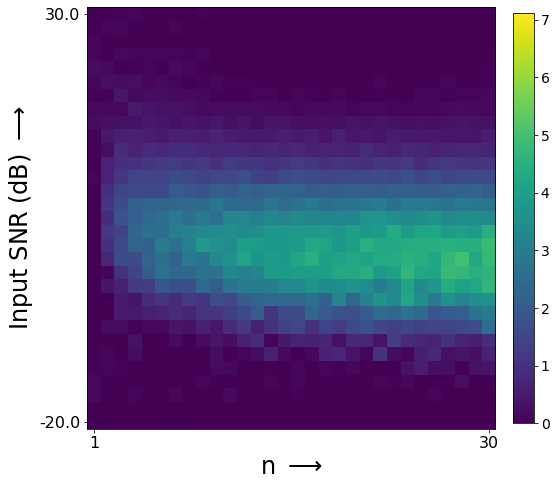

In [9]:
idx = 12
print(10*np.log10(1/(gt_sigmas[idx]**2)))

ref = err_fusion_star_snr[:, idx, :] - err_ridge_local_snr[:, idx, :]
val = err_fusion_snr[:, idx, :] - err_ridge_local_snr[:, idx, :]

plt.figure(figsize=(8, 8))
im = plt.imshow(ref, vmin=ref.min(), vmax=ref.max())
#plt.gca().invert_xaxis()
plt.xticks([0,29], [ns[0], ns[-1]], fontsize=16)
plt.xlabel(r'n $\longrightarrow$', fontsize=24)
plt.yticks([0,30], task_sim_snr[[0, -1]], fontsize=16)
plt.ylabel(r'Input SNR (dB) $\longrightarrow$', fontsize=24)
cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=14)
plt.savefig('fixed_task_sim_phase_star.pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(8, 8))
im = plt.imshow(val, vmin=ref.min(), vmax=ref.max())
#plt.gca().invert_xaxis()
plt.xticks([0,29], [ns[0], ns[-1]], fontsize=16)
plt.xlabel(r'n $\longrightarrow$', fontsize=24)
plt.yticks([0,30], task_sim_snr[[0, -1]], fontsize=16)
plt.ylabel(r'Input SNR (dB) $\longrightarrow$', fontsize=24)
cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=14)
plt.savefig('fixed_task_sim_phase.pdf', bbox_inches='tight')
plt.show()

## slice at input snr = 0dB

0.0


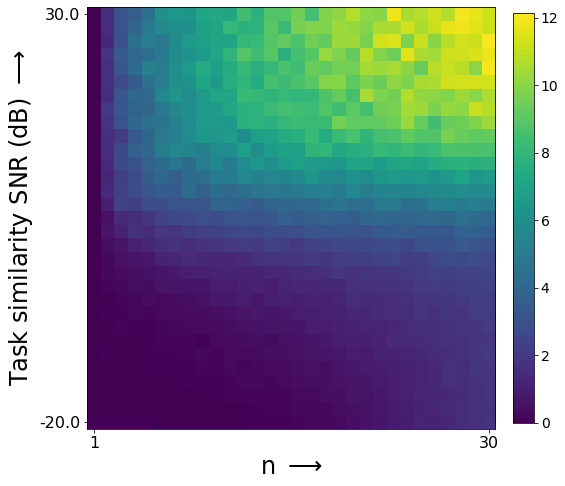

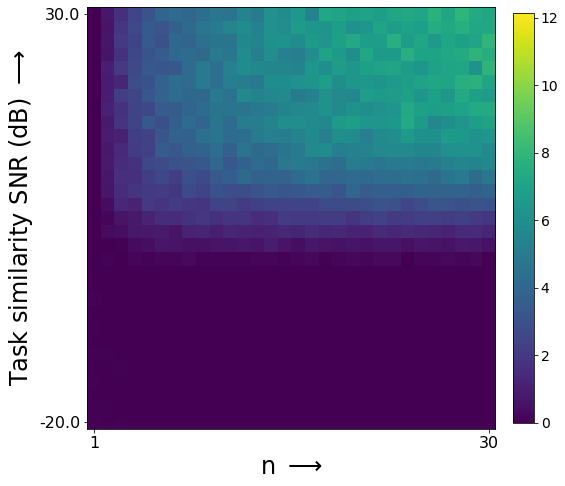

In [10]:
idx = 18
print(10*np.log10(1/(obs_sigmas[idx]**2)))

ref = err_fusion_star_snr[idx, :, :] - err_ridge_local_snr[idx, :, :]
val = err_fusion_snr[idx, :, :] - err_ridge_local_snr[idx, :, :]

plt.figure(figsize=(8, 8))
im = plt.imshow(ref, vmin=ref.min(), vmax=ref.max())
#plt.gca().invert_xaxis()
plt.xticks([0,29], [ns[0], ns[-1]], fontsize=16)
plt.xlabel(r'n $\longrightarrow$', fontsize=24)
plt.yticks([0,30], input_snr[[0, -1]], fontsize=16)
plt.ylabel(r'Task similarity SNR (dB) $\longrightarrow$', fontsize=24)
cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=14)
plt.savefig('fixed_input_snr_phase_star.pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(8, 8))
im = plt.imshow(val, vmin=ref.min(), vmax=ref.max())
#plt.gca().invert_xaxis()
plt.xticks([0,29], [ns[0], ns[-1]], fontsize=16)
plt.xlabel(r'n $\longrightarrow$', fontsize=24)
plt.yticks([0,30], input_snr[[0, -1]], fontsize=16)
plt.ylabel(r'Task similarity SNR (dB) $\longrightarrow$', fontsize=24)
cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=14)
plt.savefig('fixed_input_snr_phase.pdf', bbox_inches='tight')
plt.show()

# Community structure

- number of nodes $n$.
- $n$ is split into 3 groups - 20%, 30%, 50%.

Within each group:
- $\beta^\star \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$, $\beta^\star \in \mathbb{R}^d$.
- $\beta^\star_i \sim \mathcal{N}(\beta^\star, \sigma_{\star}^2\mathbf{I})$.
- $\mathbf{y}_i \sim \mathcal{N}(\mathbf{A}_i\beta^\star_i, \sigma_i^2\mathbf{I})$
- $\mathbf{A}_i \in \mathbb{R}^{m\times d}$, $m = d$, $\mathbf{A}_i$ is orthogonal.
- $\sigma_i = 1$.

Also:
- MSE = $\frac{1}{nd}\sum_{i=1}^n \|\hat{\beta}_i - \beta^\star_i\|^2$.

In [11]:
num_trial = 20
gt_sigma = 0.1
num_iter = 10
d = 100 # dimension of beta (ground truth)
n = 50 # number of tasks/nodes
groups = [0.2, 0.3, 0.5]
m = d# dimension of y (observation)
obs_sigma = 1

2
MSE: 0.06


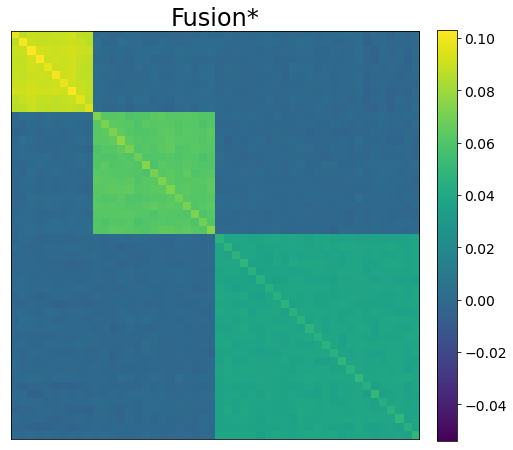

MSE: 0.1


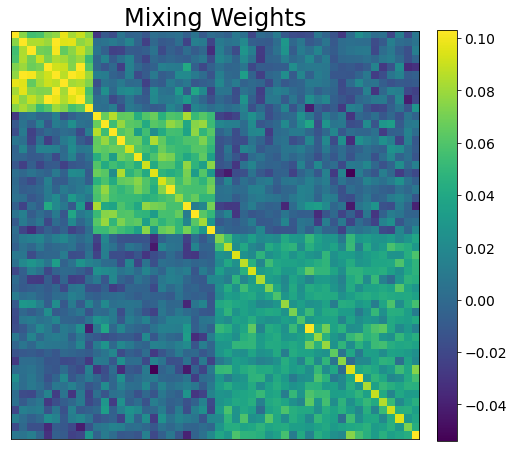

In [12]:
err_fusion = np.zeros((num_trial, num_iter))
err_ols_local = np.zeros((num_trial))
err_fusion_star = np.zeros((num_trial))
err_ols_avg = np.zeros((num_trial))
err_ridge_local = np.zeros((num_trial))

for trial in range(num_trial):
    # generate data
    bs_star, As, sigmas, ys = generate_data_community_model(d, n, m, gt_sigma, obs_sigma, groups)

    # get estimates
    ols_ests, ridge_ests, W_star, W_hats = get_all_ols_ests_one_trial(d, sigmas, bs_star, ys, As)
    
    # get MSE
    err_ols_local[trial] = get_mse(ols_ests, bs_star)
    err_ridge_local[trial] = get_mse(ridge_ests, bs_star)
    err_fusion_star[trial] = get_mse(W_star.dot(ols_ests), bs_star)
    
    tmp = np.tile(np.mean(ols_ests, axis=0), [ols_ests.shape[0],1])
    err_ols_avg[trial] = get_mse(tmp, bs_star)
    
    new_est = ols_ests

    for ii in range(num_iter):        
        new_est = W_hats[ii].dot(new_est)
        err_fusion[trial, ii] = get_mse(new_est, bs_star)
            
idx2 = np.argmin(err_fusion[-1, :])
vmin = min([W_star.min(), W_hats[idx2].min()])
vmax = min([W_star.max(), W_hats[idx2].max()])
print(idx2)
plt.figure(figsize=(8,8))
im = plt.imshow(W_star, vmin=vmin, vmax=vmax)
plt.xticks([])
plt.yticks([])
plt.title('Fusion*',fontsize=24)
print('MSE: '+str(np.round(err_fusion_star[-1], 2)))   
cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=14)
plt.savefig('community_W_star.pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(8,8))
im = plt.imshow(W_hats[idx2], vmin=vmin, vmax=vmax)
plt.xticks([])
plt.yticks([])
plt.title('Mixing Weights',fontsize=24)
print('MSE: '+str(np.round(err_fusion[-1, idx2], 2)))    
cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=14)
plt.savefig('community_W.pdf', bbox_inches='tight')
plt.show()

-20.0


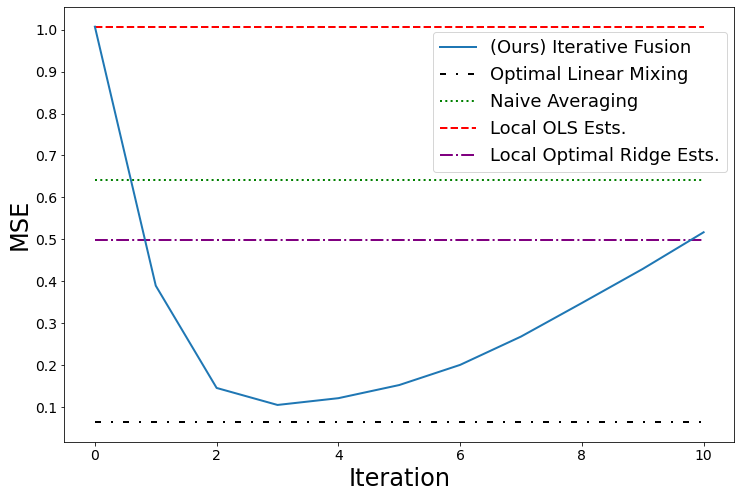

0.10546545453774858
0.5170366798550894


In [13]:
print(10*np.log10(1/((10*obs_sigma)**2)))

plt.figure(figsize=(12,8))
plt.plot(range(0, num_iter+1), np.insert(np.mean(err_fusion, 0),0,np.mean(err_ols_local)), linewidth=2, label='(Ours) Iterative Fusion')
plt.hlines(np.mean(err_fusion_star), 0, num_iter, linestyles=(0, (3, 5, 1, 5)), linewidth=2, color= 'black', label='Optimal Linear Mixing')
plt.hlines(np.mean(err_ols_avg), 0, num_iter, linestyles='dotted', linewidth=2, color= 'green', label='Naive Averaging')
plt.hlines(np.mean(err_ols_local), 0, num_iter, linestyles='dashed', linewidth=2, color='red', label='Local OLS Ests.')
plt.hlines(np.mean(err_ridge_local), 0, num_iter, linestyles='dashdot', linewidth=2, color= 'purple', label='Local Optimal Ridge Ests.')

plt.xticks(fontsize=14)
plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter(useOffset=None))
plt.gca().yaxis.set_minor_formatter(mpl.ticker.ScalarFormatter(useOffset=None))
plt.yticks(np.linspace(0.1, 1.0, 10), np.round(np.linspace(0.1, 1.0, 10),1), fontsize=14)
plt.gca().tick_params(axis='both', which='major', labelsize=14)
plt.gca().tick_params(axis='both', which='minor', labelsize=14)

plt.xlabel('Iteration',fontsize=24)
plt.ylabel('MSE',fontsize=24)
plt.legend(fontsize=18, loc=(0.55,0.62))
plt.savefig('community.pdf', bbox_inches='tight')
plt.show()
print(np.insert(np.mean(err_fusion, 0),0,np.mean(err_ols_local)).min())
print(np.insert(np.mean(err_fusion, 0),0,np.mean(err_ols_local))[-1])

# OLS "star player" setup:
Overall similar setup as above, but node 1 has smaller $\sigma_1$ (i.e. better information) than everyone else.

- $\beta^\star \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$, $\beta^\star \in \mathbb{R}^d$.
- number of nodes $n = d$.
- $\beta^\star_i \sim \mathcal{N}(\beta^\star, \sigma_{\star}^2\mathbf{I})$.
- $\mathbf{y}_i \sim \mathcal{N}(\mathbf{A}_i\beta^\star_i, \sigma_i^2\mathbf{I})$
- $\mathbf{A}_i \in \mathbb{R}^{m\times d}$, $m = d$, $\mathbf{A}_i$ is orthogonal.
- $\sigma_1 = 0.1$.
- For $i=2, \ldots, n$, set $\sigma_i = 10\sigma_{1}$.

MSE is calculated *excluding* node 1.
- MSE = $\frac{1}{(n-1)d}\sum_{i=2}^n \|\hat{\beta}_i - \beta^\star_i\|^2$

In [14]:
num_trial = 20
gt_sigma = 0.8
num_iter = 10
d = 50 # dimension of beta (ground truth)
n = d # number of tasks/nodes
m = d# dimension of y (observation)
obs_sigma = 0.1

1
MSE: 0.31


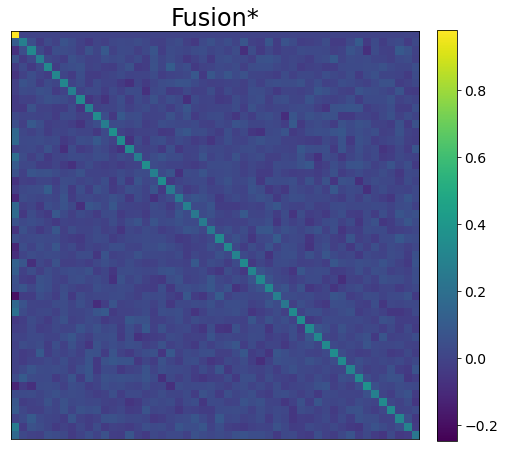

MSE: 0.49


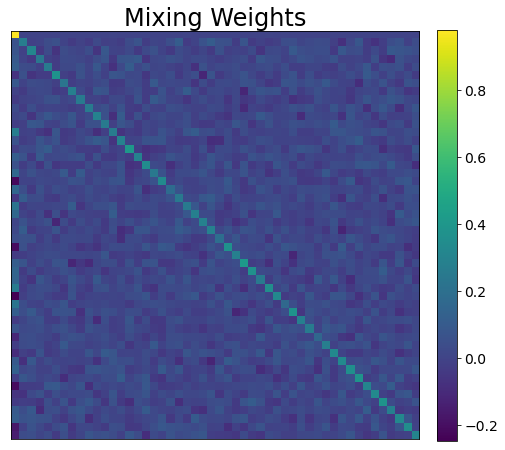

In [15]:
err_fusion = np.zeros((num_trial, num_iter))

err_ols_local = np.zeros((num_trial))
err_fusion_star = np.zeros((num_trial))
err_ols_avg = np.zeros((num_trial))
err_ols_just_first = np.zeros((num_trial))
err_ridge_local = np.zeros((num_trial))

for trial in range(num_trial):
    # generate data
    bs_star, As, sigmas, ys = generate_data_star_player_model(d, n, m, gt_sigma, obs_sigma, 10)
    
    # get estimates
    ols_ests, ridge_ests, W_star, W_hats = get_all_ols_ests_one_trial(d, sigmas, bs_star, ys, As)
    
    # get MSE
    err_ols_local[trial] = get_mse(ols_ests[1:, :], bs_star[1:, :])
    err_ridge_local[trial] = get_mse(ridge_ests[1:, :], bs_star[1:, :])
    tmp = W_star.dot(ols_ests)
    err_fusion_star[trial] = get_mse(tmp[1:, :], bs_star[1:, :])
    
    tmp = np.tile(np.mean(ols_ests, axis=0), [ols_ests.shape[0],1])
    err_ols_avg[trial] = get_mse(tmp[1:, :], bs_star[1:, :])
    
    tmp = np.tile(ols_ests[0,:], [ols_ests.shape[0],1])
    err_ols_just_first[trial] = get_mse(tmp[1:, :], bs_star[1:, :])
    
    new_est = ols_ests

    for ii in range(num_iter):
        new_est = W_hats[ii].dot(new_est)
        err_fusion[trial, ii] = get_mse(new_est[1:, :], bs_star[1:, :])

idx2 = np.argmin(err_fusion[-1, :])
vmin = min([W_star.min(), W_hats[idx2].min()])
vmax = min([W_star.max(), W_hats[idx2].max()])

print(idx2)

plt.figure(figsize=(8,8))
im = plt.imshow(W_star, vmin=vmin, vmax=vmax)
plt.xticks([])
plt.yticks([])
plt.title('Fusion*',fontsize=24)
print('MSE: '+str(np.round(err_fusion_star[-1], 2)))   
cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=14)
plt.savefig('star_player_W_star.pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(8,8))
im = plt.imshow(W_hats[idx2], vmin=vmin, vmax=vmax)
plt.xticks([])
plt.yticks([])
plt.title('Mixing Weights',fontsize=24)
print('MSE: '+str(np.round(err_fusion[-1, idx2], 2)))    
cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=14)
plt.savefig('star_player_W.pdf', bbox_inches='tight')
plt.show()

0.0


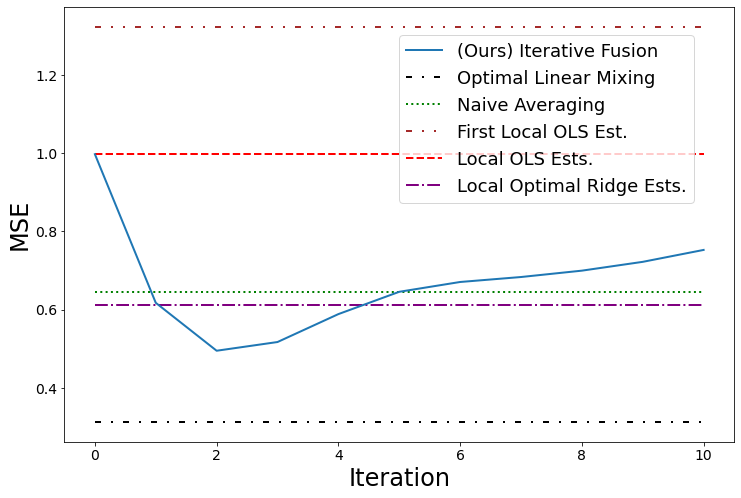

0.4946659675764531
0.7524549586193477


In [16]:
print(10*np.log10(1/((10*obs_sigma)**2)))

plt.figure(figsize=(12,8))
plt.plot(range(0, num_iter+1), np.insert(np.mean(err_fusion, 0),0,np.mean(err_ols_local)), linewidth=2, label='(Ours) Iterative Fusion')
plt.hlines(np.mean(err_fusion_star), 0, num_iter, linestyles=(0, (3, 5, 1, 5)), linewidth=2, color= 'black', label='Optimal Linear Mixing')
plt.hlines(np.mean(err_ols_avg), 0, num_iter, linestyles='dotted', linewidth=2, color= 'green', label='Naive Averaging')
plt.hlines(np.mean(err_ols_just_first), 0, num_iter, linestyles=(0, (3, 5, 1, 5, 1, 5)), linewidth=2, color= 'brown', label='First Local OLS Est.')
plt.hlines(np.mean(err_ols_local), 0, num_iter, linestyles='dashed', linewidth=2, color='red', label='Local OLS Ests.')
plt.hlines(np.mean(err_ridge_local), 0, num_iter, linestyles='dashdot', linewidth=2, color= 'purple', label='Local Optimal Ridge Ests.')

plt.xticks(fontsize=14)
plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter(useOffset=None))
plt.gca().yaxis.set_minor_formatter(mpl.ticker.ScalarFormatter(useOffset=None))
plt.yticks(fontsize=14)
plt.gca().tick_params(axis='both', which='major', labelsize=14)
plt.gca().tick_params(axis='both', which='minor', labelsize=14)

plt.xlabel('Iteration',fontsize=24)
plt.ylabel('MSE',fontsize=24)
plt.legend(fontsize=18, loc=(0.5,0.55))
plt.savefig('star_player.pdf', bbox_inches='tight')
plt.show()
print(np.insert(np.mean(err_fusion, 0),0,np.mean(err_ols_local)).min())
print(np.insert(np.mean(err_fusion, 0),0,np.mean(err_ols_local))[-1])